In [1]:
import tensorflow as tf
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import keras
import keras.layers as layers
import wandb

tf.config.list_physical_devices()

2022-07-11 05:37:50.322202: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-07-11 05:37:50.322241: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: fer
2022-07-11 05:37:50.322251: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: fer
2022-07-11 05:37:50.322330: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.48.7
2022-07-11 05:37:50.322359: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-07-11 05:37:50.322367: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.48.7


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

We want a model that can receive an image and a selection mask and that can return the segmentation of the selected fiber

In [2]:
wandb.init(project='diameterY', job_type='train-model')

wandb: Currently logged in as: fercos (warm-kanelbullar). Use `wandb login --relogin` to force relogin


In [3]:
c = wandb.config
c.seed = 0
c.epochs = 3000
c.learning_rate = 1e-4
c.loss = 'binary_crossentropy'
c.dropout = 0.3

tf.keras.utils.set_random_seed(
    c.seed
)


image: shape=(256, 256, 1), dtype=float32, max=0.615686297416687, min=0.0
segmentation: shape=(256, 256, 1), dtype=uint8, max=139, min=0


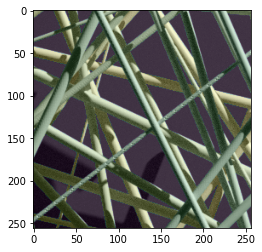

In [4]:
def load_task(dataset_path, task_id):
    # Load an image
    im = Image.open(os.path.join(dataset_path, task_id + '.png'))
    im = np.array(ImageOps.grayscale(im))
    im = im.reshape(im.shape+(1,)).astype(np.float32)/255 # one channel image
    # Load segmentation
    seg:np.ndarray = np.load(os.path.join(dataset_path, task_id+ '_seg.npz'))['y']
    return im, seg

dataset_path = '/home/fer/projects/diameterY/dataset/rendered-fibers/output'
task_id = 'train0000'
im, seg = load_task(dataset_path, task_id)

print(f'image: shape={im.shape}, dtype={im.dtype}, max={np.max(im)}, min={np.min(im)}')
print(f'segmentation: shape={seg.shape}, dtype={seg.dtype}, max={np.max(seg)}, min={np.min(seg)}')
plt.imshow(im, cmap='gray')
plt.imshow(seg, alpha=0.2)

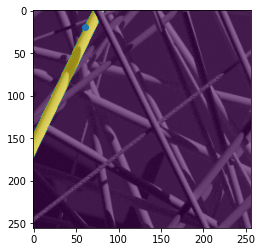

In [5]:
def select_point_and_fiber(seg):
    # Select a random point that is not background, return the mask for the fiber that the point touches.
    mask_all = seg > 0
    possible_points = np.argwhere(mask_all)
    point_index = np.random.randint(0, possible_points.shape[0]-1)
    point = possible_points[point_index]
    fiber_id = seg[point[0], point[1], point[2]]
    mask = seg == fiber_id
    selected_seg = np.zeros_like(seg, dtype=np.float32)
    selected_seg[mask] = 1.0
    return point[0:2], selected_seg

point, selected_seg = select_point_and_fiber(seg)

plt.imshow(im, cmap='gray')
plt.imshow(selected_seg, alpha=0.6)
plt.scatter(point[1], point[0])
plt.show()

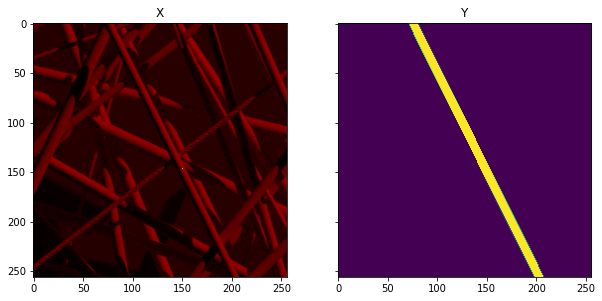

image: shape=(256, 256, 2), dtype=float32, max=1.0, min=0.0
image: shape=(256, 256, 1), dtype=float32, max=1.0, min=0.0


In [6]:
# How to create examples for training the nn
def get_example(dataset_path, task_id):
    """Creates an example for training"""
    im, seg = load_task(dataset_path, task_id)
    point, selected_seg = select_point_and_fiber(seg)
    point_channel = np.zeros_like(im, dtype=np.float32)
    point_channel[point[0], point[1], 0] = 1.0
    x = np.concatenate([im, point_channel], axis=-1)
    y = selected_seg
    return x, y

x, y = get_example(dataset_path, task_id)
preview = np.concatenate([x, np.zeros_like(x[:,:,0:1])], axis=-1) # add one channel to see it as an rgb in plt only
fig, (axX, axY) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
axX.imshow(preview)
axX.set_title('X')
axY.imshow(y)
axY.set_title('Y')
plt.show()
print(f'image: shape={x.shape}, dtype={x.dtype}, max={np.max(x)}, min={np.min(x)}')
print(f'image: shape={y.shape}, dtype={y.dtype}, max={np.max(y)}, min={np.min(y)}')

In [7]:
# generators for model training input
def example_generator(dataset_path, task_list):
    for task_id in task_list:
        yield get_example(dataset_path, task_id)

def batcher(generator, batch_size):
    batch = [], []
    counter = 0
    for x, y in generator:
        batch[0].append(x)
        batch[1].append(y)
        counter += 1
        if counter % batch_size == 0:
            yield batch
            batch = [],[]
    if len(batch[0]) > 0:
        yield batch

def train_batch_gen():
    dataset_path = '/home/fer/projects/diameterY/dataset/rendered-fibers/output'
    train_tasks = [f"train{i:04d}" for i in range(256)]
    for x, y in batcher(example_generator(dataset_path, train_tasks), batch_size):
        yield x, y

def val_batch_gen():
    dataset_path = '/home/fer/projects/diameterY/dataset/rendered-fibers/output'
    val_tasks = [f"val{i:04d}" for i in range(64)]
    for x, y in batcher(example_generator(dataset_path, val_tasks), batch_size):
        yield x, y

batch_size = 8

train_dataset:tf.data.Dataset = tf.data.Dataset.from_generator(
    train_batch_gen, output_signature=(
        tf.TensorSpec(shape=[batch_size,256,256,2], dtype=tf.float32),
        tf.TensorSpec(shape=[batch_size,256,256,1], dtype=tf.float32))
).prefetch(2)

val_dataset = tf.data.Dataset.from_generator(
    val_batch_gen, output_signature=(
        tf.TensorSpec(shape=[batch_size,256,256,2], dtype=tf.float32),
        tf.TensorSpec(shape=[batch_size,256,256,1], dtype=tf.float32))
).prefetch(2)

# for i in tqdm(train_dataset.as_numpy_iterator()):
#     pass

2022-07-11 05:37:55.696113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
def get_unet(input_size, num_classes=1):
    initial_features = 16
    inputs = layers.Input(input_size)
    conv1 = layers.Conv2D(initial_features, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(inputs)
    conv1 = layers.Conv2D(initial_features, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(initial_features*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(pool1)
    conv2 = layers.Conv2D(initial_features*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(initial_features*2**2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(pool2)
    conv3 = layers.Conv2D(initial_features*2**2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(initial_features*2**3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(pool3)
    conv4 = layers.Conv2D(initial_features*2**3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv4)
    drop4 = layers.Dropout(c.dropout)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = layers.Conv2D(initial_features*2**4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(pool4)
    conv5 = layers.Conv2D(initial_features*2**4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv5)
    drop5 = layers.Dropout(c.dropout)(conv5)

    up6 = layers.Conv2D(initial_features*2**3, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.concat([drop4,up6], axis = 3)
    conv6 = layers.Conv2D(initial_features*2**3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(merge6)
    conv6 = layers.Conv2D(initial_features*2**3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv6)

    up7 = layers.Conv2D(initial_features*2**2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = tf.concat([conv3,up7], axis = 3)
    conv7 = layers.Conv2D(initial_features*2**2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(merge7)
    conv7 = layers.Conv2D(initial_features*2**2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv7)

    up8 = layers.Conv2D(initial_features*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.concat([conv2,up8], axis = 3)
    conv8 = layers.Conv2D(initial_features*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(merge8)
    conv8 = layers.Conv2D(initial_features*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv8)

    up9 = layers.Conv2D(initial_features, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.concat([conv1,up9], axis = 3)
    conv9 = layers.Conv2D(initial_features, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(merge9)
    conv9 = layers.Conv2D(initial_features, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv9)
    conv9 = layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv9)
    conv10 = layers.Conv2D(num_classes, 1, activation = 'sigmoid', padding='same')(conv9)

    model = keras.Model(inputs, conv10)
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

In [9]:
unet = get_unet(input_size=[256,256,2], num_classes=1)


In [10]:
adam = tf.keras.optimizers.Adam(learning_rate=c.learning_rate)
# iou_metric = keras.metrics.MeanIoU(num_classes=2)
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()
iou = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)

unet.compile(
    optimizer=adam,
    loss=c.loss,
    metrics=[precision, recall, iou],
    )

In [11]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'unet-v1_checkpoint',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None
)

unet.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=c.epochs, 
    callbacks=[checkpoint, wandb.keras.WandbCallback()], 
    verbose=1)
unet.save('unet_v1')

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2022-07-11 05:37:56.452898: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-07-11 05:37:56.453012: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/3000
     19/Unknown - 47s 2s/step - loss: 0.6914 - precision: 0.0615 - recall: 0.4102 - binary_io_u: 0.3252

KeyboardInterrupt: 

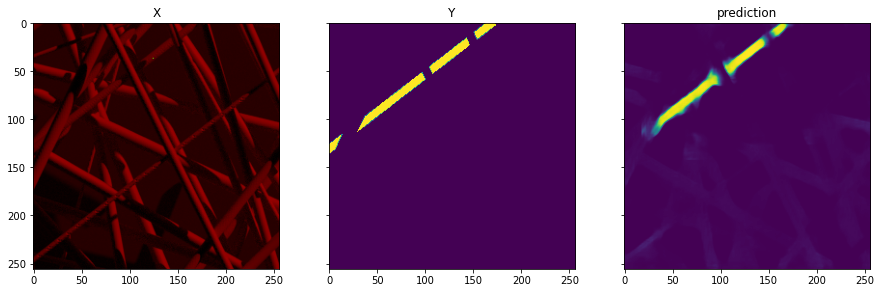

image: shape=(256, 256, 2), dtype=float32, max=1.0, min=0.0
image: shape=(256, 256, 1), dtype=float32, max=1.0, min=0.0


wandb: Network error (ConnectionError), entering retry loop.


In [ ]:
# preview examples

pred = unet(np.array([x]))[0]

preview = np.concatenate([x, np.zeros_like(x[:,:,0:1])], axis=-1) # add one channel to see it as an rgb in plt only
fig, (axX, axY, axYhat) = plt.subplots(1, 3, sharey=True, figsize=(15,5))
axX.imshow(preview)
axX.set_title('X')
axY.imshow(y)
axY.set_title('Y')
axYhat.imshow(pred)
axYhat.set_title('prediction')
plt.show()
print(f'image: shape={x.shape}, dtype={x.dtype}, max={np.max(x)}, min={np.min(x)}')
print(f'image: shape={y.shape}, dtype={y.dtype}, max={np.max(y)}, min={np.min(y)}')

In [ ]:
unet.save('unet_v1')

NameError: name 'unet' is not defined